# Combined time series figure

In [1]:
## import required packages
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.lines import Line2D
import matplotlib.ticker as ticker
import warnings
warnings.filterwarnings("ignore", module='distributed')

In [2]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:39367")
client

<Client: 'tcp://127.0.0.1:39367' processes=8 threads=32, memory=123.95 GiB>

In [3]:
# initialize s3 filesystem
s3_options = dict(anon=False)

In [4]:
# open geometry file for HH field
HH_grid = xr.open_dataset("~/efs-mount-point/mzahn/sassie/HH/GRID/GRID_GEOMETRY_SASSIE_HH_V1R1_NATIVE_LLC1080.nc")

In [5]:
# function to open zarr store with a provided s3 bucket path
def open_zarr_store(s3_path, s3_options):
    # initalize s3 file system
    s3 = s3fs.S3FileSystem(**s3_options)

    # define location of zarr store and openover_2m
    store = s3fs.S3Map(root=s3_path, s3=s3, check=False)
    zarr_store = xr.open_zarr(store)
    
    return zarr_store

### Open ZARR datasets

In [6]:
# open FWC dataset
fwc_yrs_masked = xr.open_zarr('/home/jpluser/efs-mount-point/mzahn/sassie/HH/ZARR/FWC/FWC_masked_Beaufort_final.ZARR')
fwc_yrs_masked = fwc_yrs_masked.fwc

In [7]:
sic_ds = xr.open_zarr('/home/jpluser/efs-mount-point/mzahn/sassie/HH/ZARR/SIC/SIC_masked_Beaufort.ZARR')

ice_fwc_over_2m = sic_ds.sic.where(fwc_yrs_masked>2).load()
ice_fwc_under_2m = sic_ds.sic.where(fwc_yrs_masked<2).load()

In [8]:
# open OHC zarr stores
ohc_mld_ds = xr.open_zarr('/home/jpluser/efs-mount-point/mzahn/sassie/HH/ZARR/OHC/OHC_MLD_Beaufort_final.ZARR')
ohc_mld_pyc_ds = xr.open_zarr('/home/jpluser/efs-mount-point/mzahn/sassie/HH/ZARR/OHC/OHC_PYC_Beaufort_final.ZARR')

# select all cells with FWC above and below 2
ohc_fwc_over_2m =(ohc_mld_ds.ohc/1e6).where(fwc_yrs_masked>2).load() # convert J to MJ
ohc_fwc_under_2m = (ohc_mld_ds.ohc/1e6).where(fwc_yrs_masked<2).load() # convert J to MJ

ohc_pyc_fwc_over_2m = (ohc_mld_pyc_ds.ohc_pyc/1e6).where(fwc_yrs_masked>2).load()
ohc_pyc_fwc_under_2m = (ohc_mld_pyc_ds.ohc_pyc/1e6).where(fwc_yrs_masked<2).load()

In [9]:
mld_da = xr.open_zarr('/home/jpluser/efs-mount-point/mzahn/sassie/HH/ZARR/MLD/MLD_Beaufort_final.ZARR')

# select all cells with FWC above and below 2
mld_fwc_over_2m = (mld_da.mld.where(fwc_yrs_masked>2)*-1).load()
mld_fwc_under_2m = (mld_da.mld.where(fwc_yrs_masked<2)*-1).load()

In [10]:
strat_da = xr.open_zarr('/home/jpluser/efs-mount-point/mzahn/sassie/HH/ZARR/STRAT/STRAT_Beaufort.ZARR')

# select all cells with FWC>2
strat_fwc_over_2m = strat_da.sigma.where(fwc_yrs_masked>2).load()
strat_fwc_under_2m = strat_da.sigma.where(fwc_yrs_masked<2).load()

### Add vertical lines for where SIC>=15% and remain above it for at least 5 days


In [11]:
# first day when sea ice concentration (SIC) reaches or exceeds 15% and stays above that threshold for at least 5 consecutive days
years = np.arange(2014, 2021)

ice_fwc_over_2m_dates = []
ice_fwc_under_2m_dates = []

for year in years:
    # Compute mean SIC over space
    ice_over_mean = ice_fwc_over_2m.sel(time=str(year)).mean(dim=['i', 'j'], skipna=True).compute()
    ice_under_mean = ice_fwc_under_2m.sel(time=str(year)).mean(dim=['i', 'j'], skipna=True).compute()
    
    # Convert to boolean where SIC >= 15
    ice_over_bool = ice_over_mean >= 15
    ice_under_bool = ice_under_mean >= 15

    # Find the first day where there are 5+ consecutive True values
    def find_persistent_threshold(bool_array, time_array, window=5):
        bool_np = bool_array.values
        for i in range(len(bool_np) - window + 1):
            if np.all(bool_np[i:i+window]):
                return time_array[i].values
        return np.datetime64('NaT')  # If no valid period found

    over_time = ice_over_mean['time']
    under_time = ice_under_mean['time']

    ice_over_date = find_persistent_threshold(ice_over_bool, over_time)
    ice_under_date = find_persistent_threshold(ice_under_bool, under_time)

    ice_fwc_over_2m_dates.append(ice_over_date)
    ice_fwc_under_2m_dates.append(ice_under_date)

## Combined plot

In [12]:
def compute_aligned_stats(data_over, data_under, year):
    # Select data for a specific year
    data_over_yr = data_over.sel(time=str(year))
    data_under_yr = data_under.sel(time=str(year))

    # Find the first valid sea ice day (non-NaN mean)
    mean_over = data_over_yr.mean(dim=['i', 'j'])
    first_valid_index = mean_over.notnull().argmax().compute().item()

    # Slice data from that index onward
    mean_over = mean_over.isel(time=slice(first_valid_index, None))
    mean_under = data_under_yr.mean(dim=['i', 'j']).isel(time=slice(first_valid_index, None))

    # std_over = data_over_yr.isel(time=slice(first_valid_index, None)).std(dim=['i', 'j'])
    # std_under = data_under_yr.isel(time=slice(first_valid_index, None)).std(dim=['i', 'j'])

    x = np.arange(len(mean_over))  # relative day index

    # return x, mean_over, std_over, mean_under, std_under
    return x, mean_over, mean_under

def plot_variable_row(fig, axes_row, year, variable_pairs, titles, ice_fwc_over_2m_dates, ice_fwc_under_2m_dates, row_idx):
    for j, ((data_over, data_under), title) in enumerate(zip(variable_pairs, titles)):
        ax = axes_row[j]
        # x, mean_over, std_over, mean_under, std_under = compute_aligned_stats(data_over, data_under, year)
        x, mean_over, mean_under = compute_aligned_stats(data_over, data_under, year)

        ax.plot(x, mean_over, color='tab:blue', label='FWC > 2m')

        ax.plot(x, mean_under, color='k', label='FWC < 2m')

        ax.set_xlim([0, 60])
        ax.grid(True)

        if j == 0:
            ax.set_ylabel(f"{year}", rotation=0, labelpad=30, fontsize=16)
            ax.axvline(x=np.where(mean_over.time.values == ice_fwc_over_2m_dates[row_idx])[0][0],color='tab:blue',linestyle='dashed')
            ax.axvline(x=np.where(mean_under.time.values == ice_fwc_under_2m_dates[row_idx])[0][0],color='k',linestyle='dashed')
            
        if year == 2014:
            ax.set_title(title, fontsize=16)

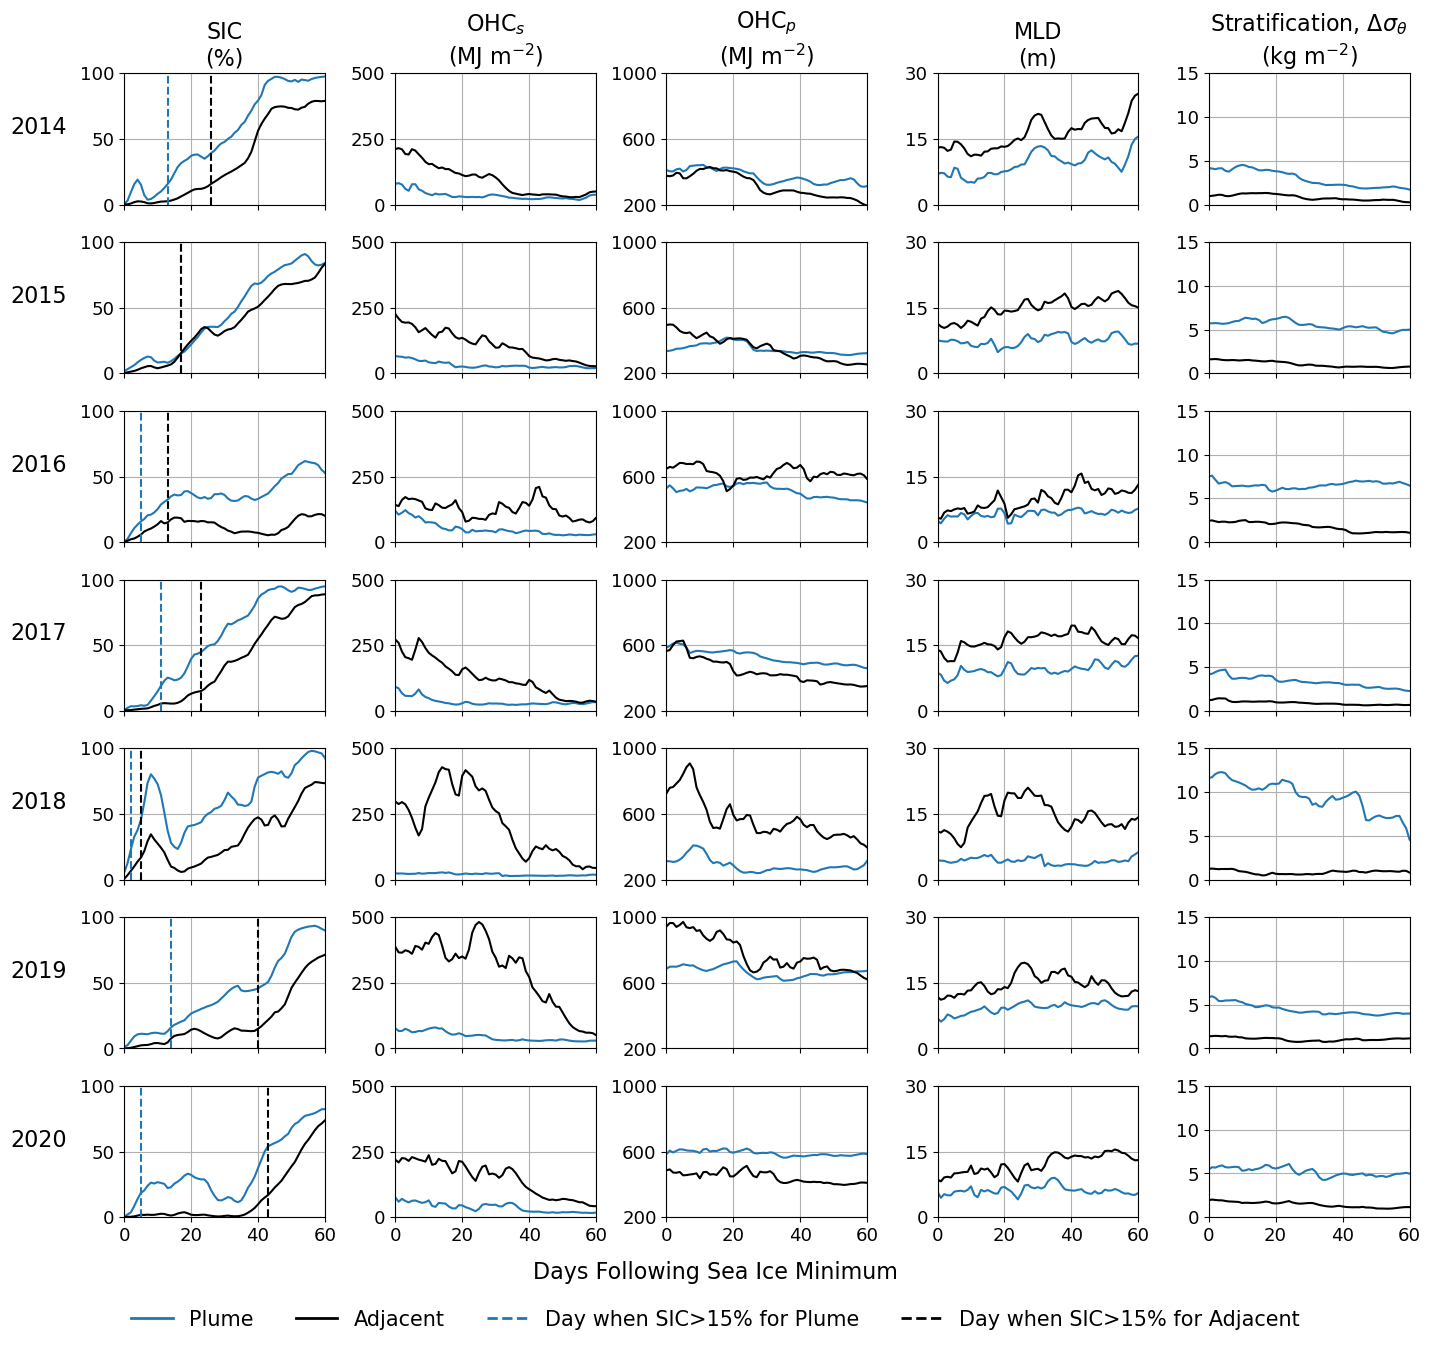

In [13]:
years = np.arange(2014, 2021)
nrows, ncols = len(years), 5

# Variable list: each is a tuple (over_2m, under_2m)
variable_pairs = [
    (ice_fwc_over_2m, ice_fwc_under_2m),
    (ohc_fwc_over_2m, ohc_fwc_under_2m),
    (ohc_pyc_fwc_over_2m, ohc_pyc_fwc_under_2m),
    (mld_fwc_over_2m, mld_fwc_under_2m),
    (strat_fwc_over_2m, strat_fwc_under_2m)
]

variable_titles = [
    'SIC\n(%)',
    'OHC$_s$\n(MJ m$^{-2}$)',
    'OHC$_p$\n(MJ m$^{-2}$)',
    'MLD\n(m)',
    'Stratification, $\Delta \\sigma_{\\theta}$\n(kg m$^{-2}$)'
]

# --- Create figure ---
plt.rcParams['font.size'] = 13
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14.5, 14), sharex=True, sharey='col')

# Plot each row/year
for i, year in enumerate(years):
    plot_variable_row(fig, axes[i], year, variable_pairs, variable_titles, ice_fwc_over_2m_dates, ice_fwc_under_2m_dates, row_idx=i)

# Custom legend in one corner subplot
custom_lines = [Line2D([0], [0], color='tab:blue', lw=2), \
                Line2D([0], [0], color='k', lw=2), \
                Line2D([0], [0], color='tab:blue', lw=2, linestyle='dashed'), \
                Line2D([0], [0], color='k', lw=2, linestyle='dashed')]

fig.legend(
    custom_lines,
    # ['FWC > 2m', 'FWC < 2m', 'Day when SIC>15% for FWC > 2m', 'Day when SIC>15% for FWC < 2m'],
    ['Plume', 'Adjacent', 'Day when SIC>15% for Plume', 'Day when SIC>15% for Adjacent'],
    loc='lower center',
    bbox_to_anchor=(0.5, -0.01),  # adjust Y as needed
    ncol=4,
    fontsize=15,
    frameon=False  # optional: no box around legend
)

# Set consistent y-axis limits per column
axes[0,0].set_ylim(0,100)
axes[0,1].set_ylim(0,500)
axes[0,1].set_yticks([0,250,500])
axes[0,2].set_ylim(200,1000)
axes[0,2].set_yticks([200,600,1000])
axes[0,3].set_ylim(0,30)
axes[0,3].set_yticks([0,15,30])
axes[0,4].set_ylim(0,15)

# --- Add shared x-label ---
fig.text(0.5, 0.04, 'Days Following Sea Ice Minimum', ha='center', fontsize=16)

# for col in range(ncols-1):
#     for row in range(nrows):
#         ax = axes[row, col]
#         labels = ax.get_yticklabels()
        # for i, label in enumerate(labels):
        #     if i % 2 == 1:  # hide every other label (e.g., odd-indexed ones)
        #         label.set_visible(False)

# Tight layout with room for x-label
plt.tight_layout(rect=[0, 0.05, 1, 0.96])
plt.subplots_adjust(wspace=0.35) 
plt.show()

fig.savefig('/home/jpluser/git_repos/SASSIE_ECCO_salinity_stratification/figures/fwc_group_time_series.png', \
            dpi=300, bbox_inches='tight')